In [1]:
#Imports

import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import initializers 

In [2]:
# Load data

# Initialize empty list to store features and corresponding labels
mfcc_features = []
labels = []
# Manual genre mapping
genre_mapping = {'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8, 'rock':9}
# Initialize path of the dataset, sample ratio, segement duration and overlap
dataset_path = "../Data"
segment_duration = 3
overlap = 0.5
SR = 22050
# SR = 44100
n_fft=2048
hop_length=512
# n_fft=4096
# hop_length=256

# Iterate through each genre folder
for genre in os.listdir(dataset_path):
    genre_path = os.path.join(dataset_path, genre)
    print(len(labels))
    print(genre)
    # Iterate through each audio file in the genre folder
    for filename in os.listdir(genre_path):
       music_path = os.path.join(genre_path, filename)
       try:
           # Load the audio file
           y, sr = librosa.load(music_path, sr=SR)

           # Calculate the number of samples per segment
           segment_samples = int(segment_duration * sr)

           # Calculate the number of samples to overlap
           overlap_samples = int(overlap * segment_samples)

           # Extract MFCC features for each segment
           for i in range(0, len(y) - segment_samples + 1, segment_samples - overlap_samples):
                segment = y[i:i + segment_samples]

                # Extract MFCC features
                mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13,n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T

                # Append the MFCC features and corresponding label
                mfcc_features.append(mfcc)
                labels.append(genre_mapping[genre])

       except Exception as e:
            print(f"Error processing {music_path}: {e}")

0
blues
1881
classical
3760
country
5638
disco
7518
hiphop
9397
jazz
11278
metal
13159
pop
15040
reggae
16921
rock


In [4]:
# Convert the labels to numpy array
labels = np.array(labels)

In [5]:
# Reshape and normalize the mel spectrogram features
mfcc1_features = [mfcc.reshape((mfcc.shape[0], mfcc.shape[1], 1)) for mfcc in mfcc_features]
mfcc1_features = np.array(mfcc1_features)
mfcc1_features = (mfcc1_features - np.mean(mfcc1_features)) / np.std(mfcc1_features)

In [10]:
# Specify the folder path
folder_path = '/content/drive/MyDrive/Load_Data'

# Ensure the folder exists, create it if necessary
os.makedirs(folder_path, exist_ok=True)

# Save the NumPy array to the folder
np.save(os.path.join(folder_path, 'mfcc1_features_base_3s.npy'), mfcc1_features)
np.save(os.path.join(folder_path, 'mfcc1_labels_base_3s.npy'), labels)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(mfcc1_features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# One-hot encode labels
y_train_onehot = to_categorical(y_train,num_classes=10)
y_val_onehot = to_categorical(y_val,num_classes=10)
y_test_onehot = to_categorical(y_test,num_classes=10)

In [8]:
n_classes = 10
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()

# Convolutional Layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(AveragePooling1D(pool_size=2, strides=2))
model.add(BatchNormalization())

# Additional Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(AveragePooling1D(pool_size=2,strides=2))
model.add(BatchNormalization())

# Another Convolutional Layer
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(AveragePooling1D(pool_size=2,strides=2))
model.add(BatchNormalization())

# Another Convolutional Layer
model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(AveragePooling1D(pool_size=2,strides=2))
model.add(BatchNormalization())

# Flatten Layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 32)           1280      
                                                                 
 average_pooling1d (Average  (None, 64, 32)            0         
 Pooling1D)                                                      
                                                                 
 batch_normalization (Batch  (None, 64, 32)            128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 64)            6208      
                                                                 
 average_pooling1d_1 (Avera  (None, 31, 64)            0         
 gePooling1D)                                                    
                                                      

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# def lr_schedule(epoch):
#     return 0.0001 * 0.9 ** epoch

# lr_scheduler = LearningRateScheduler(lr_schedule)
# train model
history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot), batch_size=64, epochs=100, callbacks=[early_stopping])

Epoch 1/100


235/235 [==============================] - 23s 62ms/step - loss: 8.5227 - accuracy: 0.2585 - val_loss: 7.6497 - val_accuracy: 0.3362
Epoch 2/100
235/235 [==============================] - 13s 56ms/step - loss: 7.4150 - accuracy: 0.3649 - val_loss: 6.7187 - val_accuracy: 0.5096
Epoch 3/100
235/235 [==============================] - 13s 55ms/step - loss: 6.7264 - accuracy: 0.4228 - val_loss: 6.0803 - val_accuracy: 0.5771
Epoch 4/100
235/235 [==============================] - 13s 55ms/step - loss: 6.1254 - accuracy: 0.4666 - val_loss: 5.5405 - val_accuracy: 0.6037
Epoch 5/100
235/235 [==============================] - 13s 56ms/step - loss: 5.5875 - accuracy: 0.4988 - val_loss: 5.0374 - val_accuracy: 0.6138
Epoch 6/100
235/235 [==============================] - 14s 58ms/step - loss: 5.0771 - accuracy: 0.5300 - val_loss: 4.5720 - val_accuracy: 0.6330
Epoch 7/100
235/235 [==============================] - 13s 56ms/step - loss: 4.5996 - accuracy: 0.5561 - val_loss: 4.1252 - val_

In [10]:
X_test1 = X_test[0:1000]

In [11]:
y_test1 = y_test_onehot[0:1000]

In [12]:
loss, accuracy = model.evaluate(X_test1, y_test1)
print(f'Test Accuracy: {accuracy:.2f}')

32/32 [==============================] - 0s 9ms/step - loss: 0.3451 - accuracy: 0.9390
Test Accuracy: 0.94


In [29]:
X_test2 = X_test[1001:1002]

In [30]:
len(X_test2)

1

In [31]:
prediction = model.predict(X_test2)

1/1 [==============================] - 0s 179ms/step


In [13]:
genre1_mapping = {0:'blues', 1:'classical', 2:'country', 3:'disco', 4:'hiphop', 5:'jazz', 6:'metal', 7:'pop', 8:'reggae', 9:'rock'}

In [38]:
# Assuming predictions_onehot is your one-hot encoded prediction
predicted_class_index = np.argmax(prediction)

# Map the index to the corresponding genre
predicted_genre = genre1_mapping.get(predicted_class_index, 'Unknown')

print(f"Predicted Genre: {predicted_genre}")

Predicted Genre: reggae


In [34]:
y_test2 = y_test_onehot[1001:1002]

In [42]:
y_test2_true = np.argmax(y_test2)

In [43]:
y_test2_true

8

In [20]:
# Specify the folder path
folder_path = 'C:/Users/dell/Desktop/Project (Final)/MGC git clone/MGC/cnn_model/model'

# Ensure the folder exists, create it if necessary
os.makedirs(folder_path, exist_ok=True)

# Save the NumPy array to the folder
model.save(os.path.join(folder_path, 'cnn_mfcc_1D.h5'))
model.save(os.path.join(folder_path, 'cnn_mfcc_1D.keras'))

In [21]:
y_predict_poss = model.predict(X_test)

59/59 [==============================] - 1s 7ms/step


In [22]:
# Convert probabilities to class labels
y_pred = np.argmax(y_predict_poss, axis=1)

In [23]:
# Assuming y_test_onehot[0] and y_pred[0] are the results you provided
y_test_true = np.argmax(y_test_onehot, axis=1)  # Convert one-hot to class labels

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate the confusion matrix
cm = confusion_matrix(y_test_true, y_pred)

In [25]:
# Create a list of labels in the correct order
ordered_labels = [genre1_mapping[i] for i in range(len(genre1_mapping))]

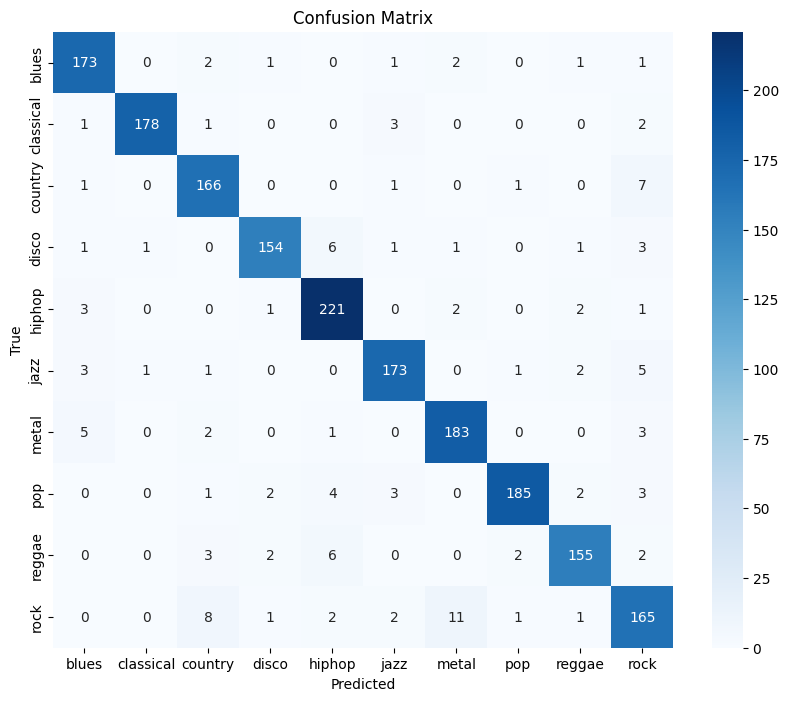

In [26]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Load data

# Initialize empty list to store features and corresponding labels
ms_f = []
# Initialize a dictionary to store total probabilities for each genre
total_probabilities = {genre: 0.0 for genre in genre1_mapping.values()}
# Initialize path of the dataset, sample ratio, segement duration and overlap
# music_path = "/content/drive/MyDrive/Data/hiphop/hiphop.00004.wav"
music_path = "/content/1759.wav"
# mp3_file_path = "/content/000825.mp3"
# wav_file_path = "/content/000825.wav"

# audio = AudioSegment.from_mp3(mp3_file_path)
# audio.export(wav_file_path, format="wav")
# music_path = "/content/000825.wav"
segment_duration = 3
overlap = 0.5
SR = 22050
# SR = 44100
n_fft=2048
hop_length=512

try:
  # Load the audio file
  y, sr = librosa.load(music_path, sr=SR)
  # Calculate the number of samples per segment
  segment_samples = int(segment_duration * sr)
  # Calculate the number of samples to overlap
  overlap_samples = int(overlap * segment_samples)
  # Extract MFCC features for each segment
  for i in range(0, len(y) - segment_samples + 1, segment_samples - overlap_samples):
    segment = y[i:i + segment_samples]
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13,n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T
    # Append the MFCC features and corresponding label
    # ms_f.append(mfcc)
    # Reshape the MFCC features to match the input shape expected by the model
    mfcc_reshaped = mfcc.reshape((1, mfcc.shape[0], mfcc.shape[1], 1))

    # Normalize if needed
    mfcc_reshaped = (mfcc_reshaped - np.mean(mfcc_reshaped)) / np.std(mfcc_reshaped)

    # Assuming 'model' is your trained CNN model
    predictions_onehot = model.predict(mfcc_reshaped)

    # Assuming predictions_onehot is your one-hot encoded prediction
    predicted_class_index = np.argmax(predictions_onehot)
    print(predicted_class_index)
    # Map the index to the corresponding genre
    predicted_genre = genre1_mapping.get(predicted_class_index, 'Unknown')
    # Get the probability for the predicted class
    predicted_probability = predictions_onehot[0, predicted_class_index]

    # Print results for each segment
    print("Predicted Genre for Segment:", predicted_genre)
    print("Probability for Predicted Genre:", f"{predicted_probability * 100:.2f}%")
    # print(predicted_genre)
    # print(f"Predicted Genre for Segment: {predicted_genre}")
    # Accumulate probability for the predicted genre
    total_probabilities[predicted_genre] += predicted_probability
except Exception as e:
  print(f"Error processing {music_path}: {e}")
# Determine the overall predicted genre based on total probabilities
overall_predicted_genre = max(total_probabilities, key=total_probabilities.get)

# Print the overall predicted genre
print("\nOverall Predicted Genre for the Entire Audio File:", overall_predicted_genre)

1/1 [==============================] - 0s 22ms/step
5
Predicted Genre for Segment: jazz
Probability for Predicted Genre: 99.89%
1/1 [==============================] - 0s 23ms/step
7
Predicted Genre for Segment: pop
Probability for Predicted Genre: 93.96%
1/1 [==============================] - 0s 25ms/step
7
Predicted Genre for Segment: pop
Probability for Predicted Genre: 60.88%
1/1 [==============================] - 0s 23ms/step
1
Predicted Genre for Segment: classical
Probability for Predicted Genre: 42.23%
1/1 [==============================] - 0s 22ms/step
1
Predicted Genre for Segment: classical
Probability for Predicted Genre: 55.65%
1/1 [==============================] - 0s 22ms/step
1
Predicted Genre for Segment: classical
Probability for Predicted Genre: 68.73%
1/1 [==============================] - 0s 39ms/step
5
Predicted Genre for Segment: jazz
Probability for Predicted Genre: 35.85%
1/1 [==============================] - 0s 33ms/step
7
Predicted Genre for Segment: pop
Prob